# Description of Goals
## Description
We are investigatig a Kickstarter datatset that includes properties of Kickstarter campaigns starting from December 2016 until Janurary 2018. The dataset includes 378,000 projects.  The dataset includes the following key properties: 
    date the campaign was launched
    the type of project
    which country it was launch from
    goal amount
    number of backers
    successful funding states
    date of campaign closing
    total amount pledged
    
We are looking for patterns of successfully funded projects among different projects. We want to see what characteristics of a project can help create high likelihood of being funded.
## Importance of Problem
Kickstarter is becoming an increasingly populat platform for startups. For new companies that cannot find or do not want Venture Capital funding or debt, Kickstarter provides an alternative for raising funds. Kickstarter helped kickoff a new era of "Crowdfunding", and continues to be the most popular crowdfunding platform for entrenpurs. We wanted to examine this dataset, because we want to help entrepenurs fund thier new company or product. A Kickstarter campaign takes a lot of time and money, and increasing numbers of people are turning to Kickstarter for funding. Therefore, if a company could know predict if their project would be successful or not before creating a campaign, they could find a better way of fundraising. 

In [1]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import neighbors, metrics, model_selection, naive_bayes, tree
from datetime import datetime
from numpy import exp
import warnings
warnings.filterwarnings('ignore')
%pylab inline

def is_currency(s):
    '''Takes in an element of the series and outputs if it is a currency'''
    return (s.isupper() and len(s) == 3)

# Create the currency conversions for both pledged and goal
# Conversion valid April 10, 2018 @ 12:00 PM Central Time
currency_conversions = {
    'USD': 1.000000,
    'GBP': 1.41540,
    'CAD': 0.793289,
    'EUR': 1.23490,
    'AUD': 0.776080,
    'SEK': 0.120317,
    'NZD': 0.736415,
    'DKK': 0.165835,
    'NOK': 0.128176,
    'CHF': 1.04558,
    'MXN': 0.0547386,
    'SGD': 0.763829,
    'HKD': 0.127393,
    'JPY': 0.00931953
}

def currency_conversion(df):
    '''Takes in an df and outputs the conversion'''
    for k,v in currency_conversions.iteritems():
        
        # Create a make for the currency
        mask_currency = (df['currency'] == k)
        df.loc[mask_currency, 'usd_goal_current'] = df['goal'] * v
        df.loc[mask_currency, 'usd_pledged_current'] = df['pledged']  * v
    return df

def clean_states(e):
    '''Takes in an elements and returns if it is in a clean state'''
    return (e in ['failed', 'successful', 'suspended', 'canceled'])


def get_month(e):
    '''Takes in a datetime element and returns the month'''
    return e.month

def name_month(e):
    '''Takes in an element from a series, and outputs the 
    string representation of the month'''

    month = int(e)
    return months[month]

months = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

def get_days(e):
    '''Takes in a DateTime element from a series and 
    returns the number of days'''
    return e.days

# Load the csv
df = pd.read_csv('ks-projects-201801.csv')

# Drop countries with name N,0"
mask_country_drop = (df['country'] != 'N,0"')
df = df[mask_country_drop]

print len(df['country'].value_counts())
print df['goal'].max()
print df['usd_pledged_real'].max()
print df['usd_goal_real'].max()

# Convert the currency into today's price
df = currency_conversion(df)

# Convert the deadline and launched columns into dtype: datetime
df['deadline'] = pd.to_datetime(df['deadline'], format='%Y-%m-%d')
df['launched'] = pd.to_datetime(df['launched'], format='%Y-%m-%d %H:%M:%S')

# Add a 'month' and 'year' coloumn to the df
df['month_deadline'] = df['deadline'].map(get_month)
df['month_launched'] = df['launched'].map(get_month)

# Add an average pledge per backer
df['average_pledged'] = df['pledged'] / df['backers']

# Create a cateogy for the month launched, goals, and quarter launched
df['month_named'] = df['month_launched'].map(name_month).astype('category')

# Bin goal amount
df['goal_binned'] = pd.qcut(df['usd_goal_real'], 10)

# Bin the months into quarters
df['quarter_binned'] = "Q1"
mask_q1 = (df['month_launched'] <= 3)
mask_q2 = ((df['month_launched'] > 3) & (df['month_launched'] <= 6))
mask_q3 = ((df['month_launched'] > 6) & (df['month_launched'] <= 9))
mask_q4 = (df['month_launched'] > 9)

df.loc[mask_q1, 'quarter_binned'] = "Q1"
df.loc[mask_q2, 'quarter_binned'] = "Q2"
df.loc[mask_q3, 'quarter_binned'] = "Q3"
df.loc[mask_q4, 'quarter_binned'] = "Q4"
df['quarter_binned'] = df['quarter_binned'].astype('category')

# Get the length of the project
df['project_length'] = df['deadline'] - df['launched']
df['project_length_days'] = df['project_length'].map(get_days)
df['project_length_days_binned'] = pd.qcut(df['project_length_days'], 3)
# print df['project_length_days'].value_counts()

# Get a baseline for the ML
# The first part is going to predict based off of cateogrical variables: 
# category, month-launched, month-deadline

# There are 6 states: failed, successful, canceled, undefied, lived, suspended
# For classification purposes 1.0 = successful, 0.0 = failed, suspended, canceled
# Create a mask of just the clean states
mask_clean_states = (df['state'].map(clean_states))
df_clean_states = df[mask_clean_states]

# Get the value counts for the clean states
vc_clean_states = df_clean_states['state'].value_counts()

# Find the baseline by dividing the total of project by the number of successful projects
# baseline = 0.359806607575
num_total_projects = vc_clean_states.sum()
num_successful_projects = vc_clean_states['successful']
baseline = float(num_successful_projects) / float(num_total_projects)

# Create a dummy binary variable for success or fail/cancel/suspended
df_clean_states['target'] = 0.0
mask_target = df_clean_states['state'] == 'successful'
df_clean_states.loc[mask_target, 'target'] = 1.0

C:\Users\tracetschida\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib
22
100000000.0
20338986.27
166361390.71


# Exploratory
## Stats

In [2]:
print df_clean_states.describe()

                 ID          goal       pledged        backers   usd pledged  \
count  3.720660e+05  3.720660e+05  3.720660e+05  372066.000000  3.720660e+05   
mean   1.074579e+09  4.931812e+04  9.755414e+03     106.977278  7.080215e+03   
std    6.191861e+08  1.182568e+06  9.626515e+04     914.519327  7.893105e+04   
min    5.971000e+03  1.000000e-02  0.000000e+00       0.000000  0.000000e+00   
25%    5.378122e+08  2.000000e+03  3.100000e+01       2.000000  1.800000e+01   
50%    1.075289e+09  5.500000e+03  6.250000e+02      12.000000  4.000000e+02   
75%    1.610135e+09  1.650000e+04  4.092972e+03      57.000000  3.056957e+03   
max    2.147476e+09  1.000000e+08  2.033899e+07  219382.000000  2.033899e+07   

       usd_pledged_real  usd_goal_real  usd_goal_current  usd_pledged_current  \
count      3.720660e+05   3.720660e+05      3.720660e+05         3.720660e+05   
mean       9.145240e+03   4.573770e+04      4.575658e+04         9.164273e+03   
std        9.162097e+04   1.151682e+

## Month with the most funding

In [3]:
series_month_pledges = df_clean_states.groupby('month_named')['usd_pledged_real'].sum().sort_values(ascending=False)
print series_month_pledges

month_named
May          3.376397e+08
October      3.291367e+08
July         3.230421e+08
November     3.225258e+08
September    3.208969e+08
March        3.194561e+08
June         2.991560e+08
April        2.953899e+08
February     2.683136e+08
August       2.498201e+08
January      2.099652e+08
December     1.272905e+08
Name: usd_pledged_real, dtype: float64


## Normalized by Number of projects in the Month with Most funding

In [4]:
series_projects_by_month = df_clean_states['month_named'].value_counts()
print (series_month_pledges / series_projects_by_month).sort_values(ascending=False)

September    10429.906859
May          10339.919962
November     10071.693120
October       9921.525420
March         9533.156407
April         9275.865542
June          9228.938105
February      9144.977784
July          8949.775513
August        7807.121433
January       7669.682215
December      6099.795468
dtype: float64


## Month with the highest average pledge

In [5]:
series_month_backers = df_clean_states.groupby('month_named')['backers'].sum()
print (series_month_pledges / series_month_backers).sort_values(ascending=False)

month_named
November     92.254616
July         90.864384
September    88.595124
June         87.685429
May          87.070327
March        86.783788
February     85.230209
October      84.354008
April        84.190834
December     81.239821
August       78.985250
January      73.145615
dtype: float64


## Which Category had the most funding, and backers

In [6]:
df = df_clean_states.copy()
series_categories_pledged = df.groupby('category')['usd_pledged_real'].sum().sort_values(ascending=False)[:10]
print series_categories_pledged
print 

series_cat_pledged_norm = (df.groupby('category')['usd_pledged_real'].sum() / df['category']\
                           .value_counts()).sort_values(ascending=False)[:10]
print series_cat_pledged_norm
print

series_categories_backers = df.groupby('category')['backers'].sum().sort_values(ascending=False)[:10]
print series_categories_backers
print

series_cat_backers_norm = (df.groupby('category')['backers'].sum() / df['category']\
                           .value_counts()).sort_values(ascending=False)[:10]
print series_cat_backers_norm

category
Product Design    6.317889e+08
Tabletop Games    4.627050e+08
Video Games       2.159422e+08
Hardware          1.547575e+08
Technology        1.414238e+08
Documentary       1.387923e+08
Gadgets           8.961746e+07
Design            7.322612e+07
Food              7.038465e+07
Wearables         6.777069e+07
Name: usd_pledged_real, dtype: float64

Camera Equipment     82131.895922
3D Printing          67167.217789
Sound                62970.574733
Wearables            56008.837669
Fabrication Tools    48963.159512
Hardware             42550.857094
Gaming Hardware      40456.838278
Tabletop Games       32885.930691
Robots               32784.924499
Space Exploration    30897.758625
dtype: float64

category
Product Design    6114407
Tabletop Games    6033518
Video Games       4413555
Documentary       1446302
Technology        1148594
Hardware          1128570
Gadgets            923100
Music              862686
Food               764749
Design             752692
Name: backers, d

## Which Main Category had the most funding and backers (normilzed too)

In [7]:
series_maincat_pledged = df.groupby('main_category')['usd_pledged_real'].sum().sort_values(ascending=False)[:10]
print series_maincat_pledged
print 


series_maincat_pledged_norm = (df.groupby('main_category')['usd_pledged_real'].sum() / df['main_category']\
                           .value_counts()).sort_values(ascending=False)[:10]
print series_maincat_pledged_norm
print

series_maincat_backers = df.groupby('main_category')['backers'].sum().sort_values(ascending=False)[:10]
print series_maincat_backers
print

series_maincat_backers_norm = (df.groupby('main_category')['backers'].sum() / df['main_category']\
                           .value_counts()).sort_values(ascending=False)[:10]
print series_maincat_backers_norm


main_category
Games           7.398133e+08
Design          7.285961e+08
Technology      6.811603e+08
Film & Video    3.893949e+08
Music           1.928839e+08
Publishing      1.327654e+08
Fashion         1.297762e+08
Food            1.251628e+08
Art             9.021672e+07
Comics          7.133717e+07
Name: usd_pledged_real, dtype: float64

Design          24480.750040
Games           21174.425572
Technology      21163.904518
Comics           6640.339751
Film & Video     6243.804291
Fashion          5751.983126
Food             5126.259912
Theater          4009.283645
Music            3916.504562
Photography      3567.282709
dtype: float64

main_category
Games           11311820
Design           7188108
Technology       5311010
Film & Video     4191963
Music            2701264
Publishing       2218584
Comics           1454046
Fashion          1395568
Food             1327368
Art              1181929
Name: backers, dtype: int64

Games           323.759123
Design          241.519656
Tec

## Of those succecssful
## Which main/categories had the most backers

In [8]:
df = df_clean_states.copy()
mask_success = df['target'] == 1.0

## Timeseries of Projects
## Graph Backers and Pledged Amounts over time

Text(0,0.5,u'Sum Pledged')

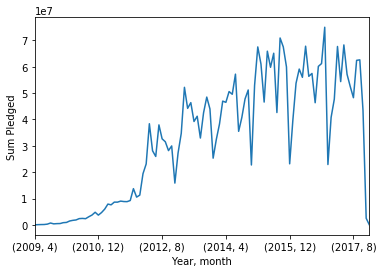

In [9]:
# Order the data by the date
df = df_clean_states.copy()
df = df.sort_values(by=['launched'])[7:]

def get_year_month(e):
    '''Takes in an element and returns the yyyy-mm'''
    d = (e.year, e.month)
    return d

# Get just the year and month
df['year_month'] = df['launched'].map(get_year_month)

df.groupby('year_month')['usd_pledged_real'].sum().plot()
xlabel('Year, month')
ylabel('Sum Pledged')

Text(0,0.5,u'Sum Backers')

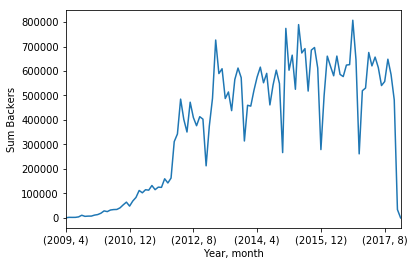

In [10]:
df.groupby('year_month')['backers'].sum().plot()
xlabel('Year, month')
ylabel('Sum Backers')

Text(0,0.5,u'Sum Goal')

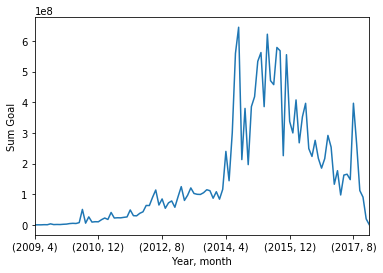

In [11]:
df.groupby('year_month')['usd_goal_real'].sum().plot()
xlabel('Year, month')
ylabel('Sum Goal')

## Number of Successes over Time

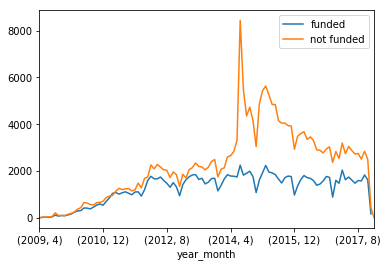

In [12]:
df2 = df.copy()

mask_success = (df['target'] == 1.0)
df = df[mask_success]

mask_fail = (df2['target'] == 0.0)
df2 = df2[mask_fail]

df.groupby('year_month')['target'].count().plot(label='funded')
df2.groupby('year_month')['target'].count().plot(label='not funded')
xlabel('Year, Month')
ylabel('Number of Projects')
legend(loc='best')

# Solution and insights
## KNN
Our problem, is a classification problem. We want to use certain features of a Kickstarter Campaign to determine if the campagin was successful or not. We first had to clean the data and convert the columns into proper datetime objects. We then got our baseline for the dataset, which is 63.55% for only picking that a project will not get funding.

In the dataset there is a feature titled "state", which says the status of the project. There are six possible states, but we are only concerned with four of them: successful, failed, canceled, and suspended. Our first approach was to use a k-Nearest-Neighbors (kNN) classifer to make predictions. In our approach we created a new target column and assigned a binary value. 1.0 was assigned for successful projects, and 0.0 was assinged for the other three states. 

In our first attempt we chose two features: number of backers and target goal converted to USD according to the date of the project launch. We used cross-validation to determine the optimal number of nearest-neighbors. Surpringly, the number of nearest-neighbors for numbers under 100 has about the same accuracy. It ranged from 91% to 93% accurate. Increasing the number of nearest neighbors more than 100 say decreased accuracy. 

(graph) Although we had really high accuracy with this kNN classifer, analyzing the model shows it is not the best option. We originally thought knowing the how many backers you need compared to your goal would help you determine how to run your project. Looking at the graph, you can see that there are two clusters of projects. Those with high backers and lower goals that succeeded, and those with little backers and higher goals that failed. This classifer is fairly intuitive and relies on data from after the project has finished. Since we want to help future Kickstarter projects. We felt that we could do better using data before the project is launched.

In [ ]:
# Start with simple KNN with two features: Number of Backers and Goal Amount
def accuracy(X, y, nn):

    model = neighbors.KNeighborsClassifier(n_neighbors=nn, weights='uniform')
    accuracies = []

    kfold = model_selection.StratifiedKFold(n_splits=3, shuffle=True).split(X, y)
    for train, holdout in kfold:
        # Select the training and testing data using the indicies from kfold
        X_train = X.iloc[train]
        X_holdout = X.iloc[holdout]
        y_train = y[train]
        y_holdout = y[holdout]

        # Fit the model
        model.fit(X_train, y_train)

        # Compute the accuracy
        current_accuracy = metrics.accuracy_score(y_holdout, model.predict(X_holdout))
        accuracies.append(current_accuracy)
        
    return accuracies

# Create sample nn
nn = [15]
scores = [accuracy(X, y, num_nbrs) for num_nbrs in nn]
print scores

# Create a design matrice
Y, X = dmatrices('target ~ 0 + backers + usd_goal_real', df_clean_states, return_type='dataframe')
y = Y['target'].values
sc = scatter(df_clean_states['backers'], df_clean_states['usd_goal_real'], c=y, cmap='bwr')
xlabel('number of backers')
ylabel('goal USD')
savefig('backers_goal.png')

pd.options.display.max_colwidth = 50
print df_clean_states[['backers', 'name']].sort_values(ascending=False, axis=0, by=['backers'])[:10]
print df_clean_states[['usd_goal_real', 'name']].sort_values(ascending=False, axis=0, by=['usd_goal_real'])[:10]

# Best Nearest Neighbor Numbers: Up to 100 nn they were all about the same accuracy between 91% and 93% 
# So you are best just using around 15 backers becuase it is faster
# Starts to see small dips over 100 nn
# Looks like the more backers and lower goal means that you have the best shot
# But that makes sense, and is only after the fact
# Backers is continuous not categorical

## Naive Bayes
Since most of the data seems independent and categorical, the Naive-Bayes classifer seemed like a better choice. There is a correlation between category/main category and goal (figure), with different categories having higher average goals. However, there is a wide spread of goals in each category and therefore it is hard to true determine how dependent the variables are. 

We created five categorical parameters: goal amounts in 10 bins, length of fundraising in three bins, category, country, and the quarter the project was started. The three bins for the length are less than 29 days, between 29 and 31 days, and over 31 days. With most of the data between 29 and 31 days.

With the Naive Bayes model we were able to get 68.92% accuracy. This is only slighty higher than the baseline of 63.55%. The class priors are slightly different than the baseline we predicted but not too much. Looking at the feature importance gives us further insight to what makes a Kickstarter project successful. 9 out of the 10 top important features are categories, and 4 of the featuers belong to the main category of technology. The only other non-category feature is the goal binned. This shows that the projects with reasonable funding goals get are important in this model for project successfulness. 

In [ ]:
# What about the category, main category, country, month launched, and goal amount
# Can we predict if the project will be successfully funded
# We first need to discretize the goal amount
# Create 20 bins of the goal amount
# usd_goal_real is discrete not catoegorical
def accuracy_nb(X, y, splits, model):
    
    accuracies = []

    kfold = model_selection.StratifiedKFold(n_splits=splits, shuffle=True).split(X, y)
    for train, holdout in kfold:
        # Select the training and testing data using the indicies from kfold
        X_train = X.iloc[train]
        X_holdout = X.iloc[holdout]
        y_train = y[train]
        y_holdout = y[holdout]

        # Fit the model
        model.fit(X_train, y_train)

        # Compute the accuracy
        current_accuracy = metrics.accuracy_score(y_holdout, model.predict(X_holdout))
        accuracies.append(current_accuracy)
        
    return accuracies

# Create a list of categorical columns that will be used
categorical_columns = ['goal_binned', 'category',
'country', 'quarter_binned', 'project_length_days_binned']

print df_clean_states['project_length_days_binned'].value_counts()

# Create a df that includes the dummy variables (0/1) for all categorical data
df_dummies = pd.get_dummies(df_clean_states[categorical_columns],
prefix=categorical_columns,columns=categorical_columns)

# Concatenate all dummy columns into the dataframe
df_clean_dummies = pd.concat([df_clean_states, df_dummies], axis=1)

# Create the formula
formula = 'target ~ 0 + {}'.format(' + '.join(['Q("{}")'.format(x) for x in df_dummies.columns.values[:205]]))

# Create the testings and training matrices
Y,X = dmatrices(formula, df_clean_dummies, return_type='dataframe')
y = Y['target'].values
    
# Build and run the model
model = naive_bayes.MultinomialNB()
accuracies = accuracy_nb(X, y, 3, model)
print accuracies

# Get the class priors
print 'Negative Class Prior'
print exp(model.class_log_prior_[0])
print 'Positive Class Prior'
print exp(model.class_log_prior_[1])

# Check class priors
print
print 'Check class priors'
print df_clean_dummies['target'].value_counts() / len(df)

# Check the likelihood and feature importance
# Seems like technology categories are the most important...
feature_importance = abs(model.feature_log_prob_[1] - model.feature_log_prob_[0])
series_feature_importance = Series(feature_importance, index=X.columns.values)
print series_feature_importance.sort_values(ascending=False)[:10]

# Need to build up cross validation

# Get the categories with the most funding
temp = df.groupby('main_category')['usd_goal_real'].mean().sort_values(ascending=False)
print temp


# Maybe use the test data for the live ones?


# Possible Features:
# Month launched and deadline
# Goal Amount
# Number of Backers
# Country of Origin
# Category and Main Category

## Decision Tree
After cross-validating the depth of the tree, 5 levels seemed to provide the best balance of small depth and higher accuracy. Unfortunately, the accuracy was only slightly above the baseline, 66.09% versus 63.55. This is not a significant jump to be able to predict if a project will be successful or not. Looking at the tree (figure), the project Length in days and the goal amount are the most important features of the decision tree as they make up the first three levels. 

This is very different than the important feature from Naives Bayes. Most of the important feature from Naive Bayes were the categories of the project. 

In [ ]:
# Create the design matrices
print df_clean_states.columns.values
Y, X = dmatrices('target ~ 0 + usd_goal_real + category + main_category + \
country + month_named + project_length_days', df_clean_states, return_type='dataframe')
y = Y['target'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Create the splits in the dataset
kfold = StratifiedKFold(n_splits=3, shuffle=True)

# Iterate over max_depth
for max_depth in [5]:
    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    scores = cross_val_score(model, X_train, y_train, cv=kfold)
    print scores.mean()
    
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
model.fit(X_train, y_train)
print metrics.accuracy_score(y_test, model.predict(X_test))

In [ ]:
import StringIO
import pydot_ng
dot_data = StringIO.StringIO()
tree.export_graphviz(model, out_file=dot_data, feature_names=X.columns.values)
pydot_ng.graph_from_dot_data(dot_data.getvalue()).write_png('tree.png')